# Retrieval-Augmented Generation (RAG)

1. Installation

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph



 2. API-Keys und Umgebungsvariablen

In [2]:
import getpass
import os
from google.colab import userdata

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] =  userdata.get('LANGSMITH_API_KEY')
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

3. Chat models

In [3]:
!pip install -qU "langchain[google-genai]"

In [4]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

4.  embeddings model

In [5]:
!pip install -qU langchain-huggingface

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

5. store model

In [7]:

!pip uninstall -y opentelemetry-sdk opentelemetry-exporter-otlp-proto-grpc opentelemetry-util opentelemetry-instrumentation chromadb langchain_chroma

#  Neu installieren: chromadb und kompatible opentelemetry
!pip install -U "chromadb>=0.4.24" "opentelemetry-sdk==1.33.0" "opentelemetry-api==1.33.0" "opentelemetry-exporter-otlp-proto-grpc==1.33.0"

# ✅Dann installiere langchain und langchain_chroma separat
!pip install -U langchain langchain-chroma


Found existing installation: opentelemetry-sdk 1.33.0
Uninstalling opentelemetry-sdk-1.33.0:
  Successfully uninstalled opentelemetry-sdk-1.33.0
Found existing installation: opentelemetry-exporter-otlp-proto-grpc 1.33.0
Uninstalling opentelemetry-exporter-otlp-proto-grpc-1.33.0:
  Successfully uninstalled opentelemetry-exporter-otlp-proto-grpc-1.33.0
Found existing installation: opentelemetry-instrumentation 0.54b0
Uninstalling opentelemetry-instrumentation-0.54b0:
  Successfully uninstalled opentelemetry-instrumentation-0.54b0
Found existing installation: chromadb 0.6.3
Uninstalling chromadb-0.6.3:
  Successfully uninstalled chromadb-0.6.3
Found existing installation: langchain-chroma 0.2.3
Uninstalling langchain-chroma-0.2.3:
  Successfully uninstalled langchain-chroma-0.2.3
  Using cached chromadb-1.0.8-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.9 kB)
  Using cached opentelemetry_sdk-1.33.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached opentelemetry_exp

In [8]:
from langchain_chroma import Chroma
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db"
)

6. Define prompt für die Frage-Antwort

In [9]:
# Define prompt for question-answering
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()
# Beispiel-Frage (vor dem Dokument)
frage = "Wie hoch ist der Prozentsatz bei SPD partei ?"

# TEST 1 – Ohne Retrieval (leerer Kontext)
gefüllter_prompt = prompt.format(context="", question=frage)
antwort = model.invoke(gefüllter_prompt)
print("\n Antwort ohne Kontext:\n", antwort.content)


 Antwort ohne Kontext:
 Ich weiß die Antwort nicht.


7. Dokumente laden

In [10]:
!pip install text_splitter



ERROR: Could not find a version that satisfies the requirement text_splitter (from versions: none)
ERROR: No matching distribution found for text_splitter


In [11]:
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
import chromadb  # Importiere ChromaDB
from langchain.vectorstores import Chroma

# 1. Webseite laden
loader = WebBaseLoader(web_paths=["https://de.wikipedia.org/wiki/Bundestagswahl_2025"])
docs = loader.load()

# 2. Aufteilen in ≥ 50 Chunks
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Chunks von max 1000 Zeichen
    chunk_overlap=200,  # 200 Zeichen Überlappung zwischen Chunks
    separators=["\n\n", "\n", ".", " ", ""]
)
# Chunks aufteilen
all_splits = splitter.split_documents(docs)

# 3. HuggingFace Embeddings initialisieren
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# 4. Vektorspeicher mit ChromaDB initialisieren
client = chromadb.Client()

# ChromaDB-Datenbank initialisieren, dies könnte auch der Name deiner spezifischen Sammlung sein
vector_store = Chroma.from_documents(documents=all_splits, embedding=embeddings, client=client, collection_name="bundestagswahl_2025")

# 5. Dokumente in den Vektorspeicher hinzufügen
vector_store.add_documents(all_splits)

# Ausgabe der Anzahl der Chunks
print(f"Anzahl der Chunks: {len(all_splits)}")


Anzahl der Chunks: 138


8. Retrieval and Generation

In [12]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [13]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [14]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [15]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}

9. Kontrollfluss

In [16]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

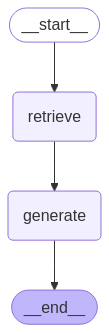

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

10.  test

In [18]:
result = graph.invoke({"question": "Wie hoch ist der Prozentsatz bei SPD partei ?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'language': 'de', 'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl 2025 – Wikipedia'}, page_content='Die Freie Demokratische Partei stürzte um über sieben Prozentpunkte auf 4,3\xa0% der Zweitstimmen ab und verschlechterte sich damit im Vergleich zur Wahl 2013. Zum zweiten Mal in der Geschichte der Bundesrepublik werden die Freidemokraten damit dem Bundestag nicht angehören. Selbst in ihrem traditionellen Stammland Baden-Württemberg erreichte sie nur noch 5,6\xa0%. Darüber hinaus lag die FDP nur in Hessen knapp oberhalb der Fünf-Prozent-Marke, ihren Tiefpunkt setzte sie in Thüringen mit 2,8\xa0% der Zweitstimmen.'), Document(metadata={'language': 'de', 'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl 2025 – Wikipedia'}, page_content='Die Freie Demokratische Partei stürzte um über sieben Prozentpunkte auf 4,3\xa0% der Zweitstimmen ab und verschlechterte sich damit im Vergleich zur W

11. langGrapgh ablauf

In [19]:
for step in graph.stream(
    {"question": "Wie hoch ist der Prozentsatz bei SPD partei ?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(metadata={'language': 'de', 'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl 2025 – Wikipedia'}, page_content='Die Freie Demokratische Partei stürzte um über sieben Prozentpunkte auf 4,3\xa0% der Zweitstimmen ab und verschlechterte sich damit im Vergleich zur Wahl 2013. Zum zweiten Mal in der Geschichte der Bundesrepublik werden die Freidemokraten damit dem Bundestag nicht angehören. Selbst in ihrem traditionellen Stammland Baden-Württemberg erreichte sie nur noch 5,6\xa0%. Darüber hinaus lag die FDP nur in Hessen knapp oberhalb der Fünf-Prozent-Marke, ihren Tiefpunkt setzte sie in Thüringen mit 2,8\xa0% der Zweitstimmen.'), Document(metadata={'language': 'de', 'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl 2025 – Wikipedia'}, page_content='Die Freie Demokratische Partei stürzte um über sieben Prozentpunkte auf 4,3\xa0% der Zweitstimmen ab und verschlechterte sich damit im

12. Anpassen das prompt
(5 versuch)

In [20]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [21]:
for step in graph.stream(
    {"question": "Wann fand die Bundestagswahl 2025 statt?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(metadata={'language': 'de', 'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl 2025 – Wikipedia'}, page_content='Bundestagswahl 2025 – Wikipedia\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nZum Inhalt springen\n\n\n\n\n\n\n\nHauptmenü\n\n\n\n\n\nHauptmenü\nIn die Seitenleiste verschieben\nVerbergen\n\n\n\n\t\tNavigation\n\t\n\n\nHauptseiteThemenportaleZufälliger ArtikelSpezialseiten\n\n\n\n\n\n\t\tMitmachen\n\t\n\n\nArtikel verbessernNeuen Artikel anlegenAutorenportalHilfeLetzte ÄnderungenKontakt\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSuche\n\n\n\n\n\n\n\n\n\n\n\nSuchen\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nErscheinungsbild\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSpenden\n\nBenutzerkonto erstellen\n\nAnmelden\n\n\n\n\n\n\n\n\nMeine Werkzeuge\n\n\n\n\n\nSpenden Benutzerkonto erstellen Anmelden\n\n\n\n\n\n\t\tSeiten für nicht angemeldete Benutzer weitere Informationen\n\n\n\nBeiträgeDiskus

In [22]:
from langchain_core.prompts import PromptTemplate

template = """Here is some information that might help answer the question below.
If you're not sure about the answer, it's okay to say you don't know.
Please keep the answer short and friendly – no more than three sentences.
End your answer with: "Hope that helps!"

{context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

In [23]:
for step in graph.stream(
    {"question": "Welche Partei bekam die meisten Zweitstimmen bei der Wahl 2025?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(metadata={'language': 'de', 'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl 2025 – Wikipedia'}, page_content='Außerhalb der genannten Parteien gewann nur der von der Sperrklausel ausgenommene Südschleswigsche Wählerverband ein Mandat. Die Partei der dänischen Minderheit erreichte 76.126 Zweitstimmen, was 4,0\xa0% der Zweitstimmen in Schleswig-Holstein entsprach. Rechnerisch hätten der Partei bereits 34.100 Stimmen für das erste Mandat gereicht; für ein zweites Mandat hätte sie rund 102.500 Stimmen erzielen müssen. Schon 2021 hatte der SSW 55.578 Zweitstimmen in Schleswig-Holstein erhalten, was 3,2\xa0% der dortigen Zweitstimmen entsprach.[32][120] Die Freien Wähler, welche den Einzug in den Bundestag als Ziel ausgaben, verloren im Gegenteil einen Prozentpunkt im Vergleich zur Wahl 2021.'), Document(metadata={'language': 'de', 'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl

In [24]:
template = """Based on the provided information, answer the following question as clearly and accurately as possible.
Do not guess; if the information is insufficient, respond with "Information not available."
Limit your answer to three concise sentences.
Conclude with: "Thank you for your question."

{context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

In [25]:
for step in graph.stream(
    {"question": "Welche Partei bekam die meisten Zweitstimmen bei der Wahl 2025?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(metadata={'language': 'de', 'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl 2025 – Wikipedia'}, page_content='Außerhalb der genannten Parteien gewann nur der von der Sperrklausel ausgenommene Südschleswigsche Wählerverband ein Mandat. Die Partei der dänischen Minderheit erreichte 76.126 Zweitstimmen, was 4,0\xa0% der Zweitstimmen in Schleswig-Holstein entsprach. Rechnerisch hätten der Partei bereits 34.100 Stimmen für das erste Mandat gereicht; für ein zweites Mandat hätte sie rund 102.500 Stimmen erzielen müssen. Schon 2021 hatte der SSW 55.578 Zweitstimmen in Schleswig-Holstein erhalten, was 3,2\xa0% der dortigen Zweitstimmen entsprach.[32][120] Die Freien Wähler, welche den Einzug in den Bundestag als Ziel ausgaben, verloren im Gegenteil einen Prozentpunkt im Vergleich zur Wahl 2021.'), Document(metadata={'language': 'de', 'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl

In [26]:
template = """Use the information below to answer the question.
If you don't know the answer, just say: "I’m not sure from this information."
Keep the answer short – up to three sentences – and easy to understand.
Always say: "Thanks for your question!" at the end.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [27]:
for step in graph.stream(
    {"question": "Wie hoch war die Wahlbeteiligung bei der Bundestagswahl 2025?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(metadata={'language': 'de', 'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl 2025 – Wikipedia'}, page_content='↑ Noch nicht Rekord: Bundestagswahl verzeichnet hohen Anstieg bei Wahlbeteiligung. 23.\xa0Februar 2025, abgerufen am 23.\xa0Februar 2025.\xa0\n\n↑ Bundestagswahl 2025: Wahlbeteiligung steigt auf 83 bis 84 Prozent. In: Der Spiegel. 23.\xa0Februar 2025, ISSN\xa02195-1349 (spiegel.de [abgerufen am 23.\xa0Februar 2025]).\xa0\n\n↑ Ergebnisse Deutschland – Die Bundeswahlleiterin. Abgerufen am 24.\xa0Februar 2025.\xa0\n\n↑ Weniger Wähler: Stimmberechtigte bei Bundestagswahl sinken im Vergleich zu 2021, n-tv, 4. Dezember 2024: „Im Bundesgebiet sind aktuell mindestens 59,2 Millionen Deutsche wahlberechtigt, wie das Statistische Bundesamt am Mittwoch schätzte. 2021 waren es noch rund 61,2 Millionen Personen. ‚Die Differenz geht vor allem auf die demografische Entwicklung zurück‘, hieß es zur Begründung.“\n\n↑ Bund

In [28]:
template = """Read the context and use it to answer the question below.
Do not provide an answer unless the context clearly supports it.
Answer in no more than three sentences.
End your response with: "Thanks for asking!"

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [29]:
for step in graph.stream(
    {"question": "Welche Partei stellte 2025 den Kanzlerkandidaten Friedrich Merz?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")



{'retrieve': {'context': [Document(metadata={'language': 'de', 'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl 2025 – Wikipedia'}, page_content='↑ CDU und CSU: Merz wird Kanzlerkandidat der Union. In: Tagesschau. Norddeutscher Rundfunk, 18.\xa0September 2024, abgerufen am 18.\xa0September 2024.\xa0\n\n↑ Wüst sieht von Kanzlerkandidatur ab – und unterstützt Merz. In: Spiegel. 16.\xa0September 2024, abgerufen am 16.\xa0September 2024.\xa0\n\n↑ Das Kanzlerkandidaten-Karussell der Union. ZDF, 4.\xa0Oktober 2023, abgerufen am 20.\xa0Oktober 2023.\xa0\n\n↑ Baerbock schließt erneute Kanzlerkandidatur aus. In: tagesschau.de. 10.\xa0Juli 2024, abgerufen am 8.\xa0November 2024.\xa0\n\n↑ Matthias Deiß: So begründet Habeck seine Kanzlerkandidatur. In: tagesschau.de. 8.\xa0November 2024, abgerufen am 8.\xa0November 2024.\xa0\n\n↑ Markus Balser, Vivien Timmler: Grüne: Robert Habeck tritt im Spitzenduo mit Annalena Baerbock an. 14.\xa0November 2024, abgerufen a

13. Query Analysis für 13 section

In [30]:
from math import ceil

total = len(all_splits)
chunk_size = ceil(total / 10)

for i, doc in enumerate(all_splits):
    section = (i // chunk_size) + 1
    doc.metadata["section"] = str(section)


In [31]:
from collections import Counter

sections = [doc.metadata.get("section") for doc in all_splits]
count_per_section = Counter(sections)

print(" Dokumentanzahl pro Sektion:")
for section, count in sorted(count_per_section.items()):
    print(f"  Section {section}: {count} Dokumente")

 Dokumentanzahl pro Sektion:
  Section 1: 14 Dokumente
  Section 10: 12 Dokumente
  Section 2: 14 Dokumente
  Section 3: 14 Dokumente
  Section 4: 14 Dokumente
  Section 5: 14 Dokumente
  Section 6: 14 Dokumente
  Section 7: 14 Dokumente
  Section 8: 14 Dokumente
  Section 9: 14 Dokumente


14. Aktualisieren Sie die Dokumente in unserem Vektorspeicher

In [32]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

15. Define a schema for the search query.

In [33]:
from typing import Literal
from typing_extensions import Annotated
from typing import TypedDict

class Search(TypedDict):
    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"],
        ...,
        "Section to query (1–10)."
    ]


16.  Define prompt and  state for application

In [34]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [35]:

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = model.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

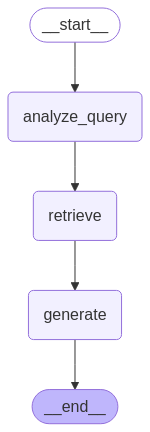

In [36]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
for step in graph.stream(
    {"question": "Wie hoch ist der Prozentsatz bei SPD partei ?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Wie hoch ist der Prozentsatz bei SPD partei ?', 'section': '1'}}}

----------------

{'retrieve': {'context': [Document(id='10e3d8fc-33bb-405f-aeb5-fd2202b78ada', metadata={'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl 2025 – Wikipedia', 'language': 'de', 'section': '1'}, page_content='Da insgesamt 14\xa0% der Zweitstimmen auf Parteien entfielen, die nicht in den Bundestag einzogen, kamen Union und SPD mit zusammen 44,9\xa0% der Zweitstimmen auf 52\xa0% der Sitze. Die noch im Parlament vertretenen Parteien, die bisher Bundesregierungen bildeten (Union, SPD, Grüne), verfügen im Bundestag nach diesem Ergebnis nicht mehr über eine gemeinsame Zweidrittelmehrheit, die unter anderem für Grundgesetzänderungen erforderlich ist.\nDie Wahlbeteiligung war mit 82,5\xa0% die höchste im wiedervereinigten Deutschland.[2][3][4] Vor allem wegen der demographischen Entwicklung[5] ging die Zahl der Wahlberechtigten von 61,17

17. Dialog flow (multi-turn interaction)

In [38]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [39]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [40]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = model.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = model.invoke(prompt)
    return {"messages": [response]}

In [41]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

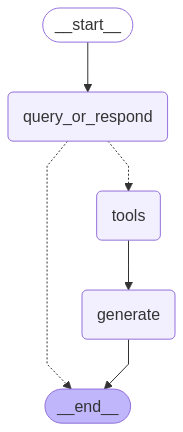

In [42]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

18. beispiel ohne Memory

In [43]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [44]:
input_message = "Was wissen Sie über die CDU?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Was wissen Sie über die CDU?
================================== Ai Message ==================================
Tool Calls:
  retrieve (2bb3cb7c-f5ad-4b0d-a365-e81d4c05b49b)
 Call ID: 2bb3cb7c-f5ad-4b0d-a365-e81d4c05b49b
  Args:
    query: Was ist die CDU?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl 2025 – Wikipedia', 'language': 'de', 'section': '8'}
Content: Am 9. April einigten sich die Verhandler der drei Parteien auf einen Koalitionsvertrag, der anschließend vom CSU-Vorstand, einem Parteitag der CDU und im Falle der SPD auch durch ein Mitgliedervotum bestätigt wurde, sodass die Parteispitzen am 5. Mai den Koalitionsvertrag gemeinsam unterzeichneten.[146][147] Personell sind darin neben dem Bundeskanzler Friedrich Merz 17 Minister vorgesehen, von denen 7 (

In [45]:
input_message = "Wie hoch ist der Prozentsatz bei diese partei ?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Wie hoch ist der Prozentsatz bei diese partei ?
================================== Ai Message ==================================

Auf welche Partei beziehst du dich? Bitte gib den Namen der Partei an.


19. Memory (to track context across messages)

In [46]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [47]:
input_message = "Was wissen Sie über die CDU?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Was wissen Sie über die CDU?
================================== Ai Message ==================================
Tool Calls:
  retrieve (19fbb830-166e-4d1e-bf9d-6793a851238d)
 Call ID: 19fbb830-166e-4d1e-bf9d-6793a851238d
  Args:
    query: Was ist die CDU?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl 2025 – Wikipedia', 'language': 'de', 'section': '8'}
Content: Am 9. April einigten sich die Verhandler der drei Parteien auf einen Koalitionsvertrag, der anschließend vom CSU-Vorstand, einem Parteitag der CDU und im Falle der SPD auch durch ein Mitgliedervotum bestätigt wurde, sodass die Parteispitzen am 5. Mai den Koalitionsvertrag gemeinsam unterzeichneten.[146][147] Personell sind darin neben dem Bundeskanzler Friedrich Merz 17 Minister vorgesehen, von denen 7 (

In [48]:
input_message = "Wie hoch ist der Prozentsatz bei diese partei in 2025?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Wie hoch ist der Prozentsatz bei diese partei in 2025?
================================== Ai Message ==================================
Tool Calls:
  retrieve (7790b5bc-9aab-443f-97fd-760e60b62b12)
 Call ID: 7790b5bc-9aab-443f-97fd-760e60b62b12
  Args:
    query: Wie hoch ist der Prozentsatz der CDU bei der Bundestagswahl 2025?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://de.wikipedia.org/wiki/Bundestagswahl_2025', 'title': 'Bundestagswahl 2025 – Wikipedia', 'language': 'de', 'section': '2'}
Content: Bundestagswahl 2021Endgültiges Ergebnis – Zweitstimmen[27] %3020100
25,724,114,711,410,44,98,8
SPDUnionGrüneFDPAfDLinkeSonst.
Vorherige Bundestagswahl[Bearbeiten | Quelltext bearbeiten]
→ Hauptartikel: Bundestagswahl 2021
An der Bundestagswahl 2021 beteiligten sich 76,35 % der wahlberechtigten Deutschen.
Für CDU/CSU und SPD, auf d

# bonus multi

prompt

In [49]:
# Build a sample vectorDB
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load blog post
loader = WebBaseLoader("https://de.wikipedia.org/wiki/Bundestagswahl_2025")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000 , chunk_overlap=200)
splits = text_splitter.split_documents(data)

# VectorDB
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

In [50]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.chat_models import init_chat_model



# LLM initialisieren
llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai", temperature=0)

# MultiQueryRetriever konfigurieren
question = "wann wird die Abstimmung im Bundestag über die Vertrauensfrage?"

retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vectordb.as_retriever(), llm=llm
)



In [51]:
# Set logging for the queries
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [52]:
unique_docs = retriever_from_llm.invoke(question)
len(unique_docs)

INFO:langchain.retrievers.multi_query:Generated queries: ['Wann findet die Vertrauensabstimmung im Bundestag statt?', 'Welcher Termin ist für die Vertrauensfrage im Bundestag angesetzt?', 'An welchem Tag stimmt der Bundestag über das Misstrauen gegenüber der Regierung ab?']


7

In [62]:
import shutil

# Alles im aktuellen Arbeitsverzeichnis in eine ZIP-Datei packen
shutil.make_archive("colab_backup", "zip", ".")

# Download-Link erzeugen
from google.colab import files
files.download("colab_backup.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>